In [1]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0=all logs, 1=filter INFO, 2=filter WARNING, 3=filter ERROR
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt
import pandas as pd

2025-09-25 16:29:06.639363: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758796146.796821   24316 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758796146.844069   24316 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1758796147.102856   24316 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758796147.102929   24316 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1758796147.102937   24316 computation_placer.cc:177] computation placer alr

In [2]:
# ---------------- Parameters ----------------
IMG_SIZE = 128
DATA_PATH = "./Data/Scores"   # root folder containing Circle/, Square/, etc.
BATCH_SIZE = 32
EPOCHS = 20

In [3]:
# ---------------- Data Preparation ----------------
X, y, class_names = [], [], []
class_map = {}

In [4]:
print("[INFO] Loading dataset...")

[INFO] Loading dataset...


In [10]:
X = []
y = []

for shape_name in os.listdir(DATA_PATH):  # e.g., Circle, Square, Triangle
    shape_path = os.path.join(DATA_PATH, shape_name)
    if not os.path.isdir(shape_path):
        continue
    
    for score in os.listdir(shape_path):  # e.g., 0, 1, 2, ...
        score_path = os.path.join(shape_path, score)
        if not os.path.isdir(score_path):
            continue
        
        label = f"{shape_name}_{score}"
        if label not in class_map:
            class_map[label] = len(class_map)
            class_names.append(label)
        
        for file in os.listdir(score_path):
            if file.endswith(".png") or file.endswith(".jpg"):
                path = os.path.join(score_path, file)
                img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                X.append(img)
                y.append(class_map[label])

X = np.array(X, dtype="float32") / 255.0
X = np.expand_dims(X, -1)   # shape = (N,128,128,1)
y = np.array(y)
y_cat = to_categorical(y, num_classes=len(class_map))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_cat, test_size=0.2, random_state=42
)

In [11]:
print(f"[INFO] Dataset loaded: {X.shape[0]} samples, {len(class_map)} classes")
print("[INFO] Classes:", class_names)

[INFO] Dataset loaded: 4297 samples, 34 classes
[INFO] Classes: ['Triangle_0', 'Triangle_4', 'Triangle_5', 'Star_3', 'Star_2', 'Star_0', 'Star_4', 'Star_5', 'Wave_3', 'Wave_2', 'Wave_0', 'Wave_4', 'Circle_3', 'Circle_2', 'Circle_0', 'Circle_4', 'Square_0', 'Square_4', 'Square_5', 'Overlapped pencils_3', 'Overlapped pencils_2', 'Overlapped pencils_0', 'Overlapped pencils_4', 'Overlapped pencils_6', 'Overlapped pencils_5', 'Overlapped circle_2', 'Overlapped circle_0', 'Overlapped circle_4', 'Overlapped circle_6', 'Overlapped circle_5', 'Diagonal_3', 'Diagonal_0', 'Diagonal_4', 'Diagonal_5']


In [12]:
# ---------------- Global CNN Model ----------------
base = EfficientNetB0(include_top=False, input_shape=(128,128,1), weights=None)

model = models.Sequential([
    base,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(len(class_map), activation="softmax")
])

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

2025-09-25 16:45:44.347016: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [13]:
# ---------------- Training ----------------
print("[INFO] Training model...")
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1
)

[INFO] Training model...
Epoch 1/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 151s 1s/step - accuracy: 0.1635 - loss: 3.0457 - val_accuracy: 0.0828 - val_loss: 2.8660
Epoch 2/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.4754 - loss: 1.8133 - val_accuracy: 0.1163 - val_loss: 3.6518
Epoch 3/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.6570 - loss: 1.1292 - val_accuracy: 0.0828 - val_loss: 4.8827
Epoch 4/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.7070 - loss: 0.9415 - val_accuracy: 0.1163 - val_loss: 4.0079
Epoch 5/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 118s 1s/step - accuracy: 0.7536 - loss: 0.7688 - val_accuracy: 0.1163 - val_loss: 4.0872
Epoch 6/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 119s 1s/step - accuracy: 0.7972 - loss: 0.6078 - val_accuracy: 0.2587 - val_loss: 2.8709
Epoch 7/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.8274 - loss: 0.5236 - val_accuracy: 0.4084 - val_loss: 2.2092
Epoch 8/20
86/86 ━━━━━━━━━━━━━━━━━━━━ 113s 1s/step - accuracy: 0.8520 - loss: 0.4352 -

In [14]:
# Save
pd.DataFrame(history.history).to_csv("global_cnn_training_history.csv", index=False)

In [15]:
# ---------------- Evaluation ----------------
print("[INFO] Evaluating model...")
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {acc:.4f}")


[INFO] Evaluating model...
Test Accuracy: 0.5093


In [16]:
# ---------------- Save Model ----------------
model.save("global_cnn_model.h5")
print("[INFO] Model saved as global_cnn_model.h5")

[INFO] Model saved as global_cnn_model.h5


In [17]:
# ---------------- Prediction Helper ----------------
def decode_prediction(pred_idx):
    return class_names[pred_idx]

In [18]:
# Plot training & validation accuracy/loss
def plot_training(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Accuracy
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Loss
    plt.figure(figsize=(8, 5))
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

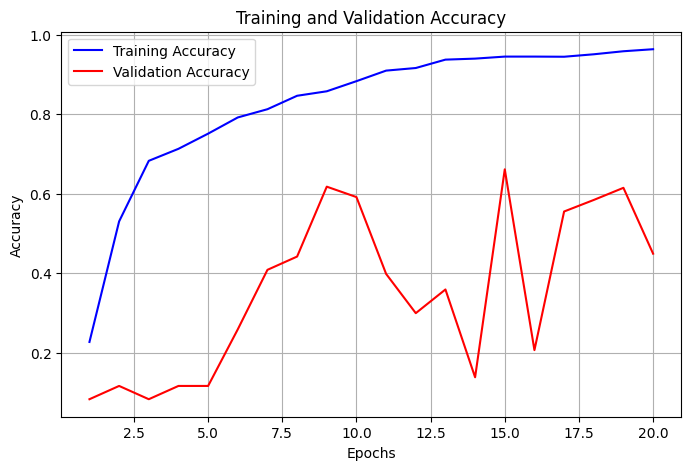

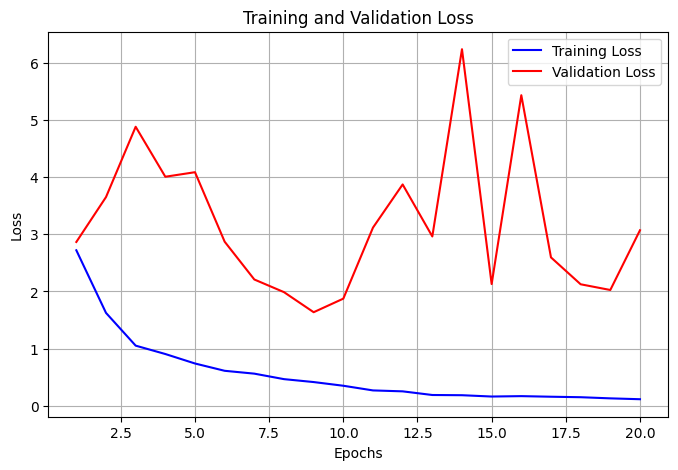

In [19]:
# Call after training
plot_training(history)